In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, places, viz_tools, visualisations
import xarray as xr
import pandas as pd
import pickle
import os
import bloomdrivers

%matplotlib inline

In [2]:
start=dt.datetime(2019,1,1)
end=dt.datetime(2019,3,31)
year=str(start.year)
modver='201812'
loc='S3'

savedir='/ocean/aisabell/MEOPAR/extracted_files'

fname=f'JanToMarch_TimeSeries_{year}_{loc}_{modver}.pkl'
savepath=os.path.join(savedir,fname)
recalc=False

Text(0, 0.5, 'Latitude')

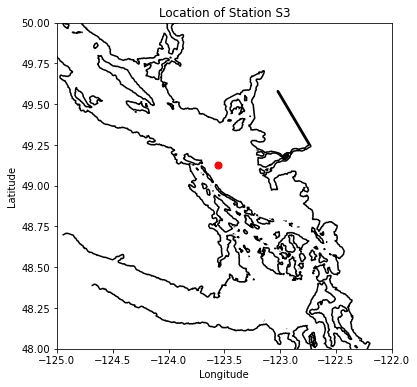

In [3]:
loc='S3'

# lat and lon informatin for place:
lon,lat=places.PLACES['S3']['lon lat']
# get place information on SalishSeaCast grid:
ij,ii=places.PLACES['S3']['NEMO grid ji']
# GEM2.5 grid ji is atm forcing grid for ops files
jw,iw=places.PLACES['S3']['GEM2.5 grid ji']

fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords ='map', isobath=.1)
ax.plot(lon, lat, '.', markersize=14, color='red')
ax.set_ylim(48,50)
ax.set_xlim(-125,-122)
ax.set_title('Location of Station S3')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [4]:
if recalc==True or not os.path.isfile(savepath):
    basedir='/results/SalishSea/nowcast-green.201812/'
    nam_fmt='nowcast'
    flen=1 # files contain 1 day of data each
    ftype= 'ptrc_T' # load bio files
    tres=24 # 1: hourly resolution; 24: daily resolution  
    flist=et.index_model_files(start,end,basedir,nam_fmt,flen,ftype,tres)
    flist3 = et.index_model_files(start,end,basedir,nam_fmt,flen,"grid_T",tres)
    fliste3t = et.index_model_files(start,end,basedir,nam_fmt,flen,"carp_T",tres)

    ik=0
    with xr.open_mfdataset(flist['paths']) as bio:
        bio_time=np.array(bio.time_centered[:])
        sno3=np.array(bio.nitrate.isel(deptht=ik,y=ij,x=ii))
        sdiat=np.array(bio.diatoms.isel(deptht=ik,y=ij,x=ii))
        sflag=np.array(bio.flagellates.isel(deptht=ik,y=ij,x=ii))
        scili=np.array(bio.ciliates.isel(deptht=ik,y=ij,x=ii))
        no3_3m=np.array(bio.nitrate.sel(deptht=slice('0','3'),y=ij,x=ii)) 
        diat_3m=np.array(bio.diatoms.sel(deptht=slice('0','3'),y=ij,x=ii))
        flag_3m=np.array(bio.flagellates.sel(deptht=slice('0','3'),y=ij,x=ii))
        cili_3m=np.array(bio.ciliates.sel(deptht=slice('0','3'),y=ij,x=ii))
        microzoo=np.array(bio.microzooplankton.isel(y=ij,x=ii))
        mesozoo=np.array(bio.mesozooplankton.isel(y=ij,x=ii))
        no3_past_250m=np.array(bio.nitrate.sel(deptht=slice('250',stop=None),y=ij,x=ii))
        no3_30m_90m=np.array(bio.nitrate.sel(deptht=slice('30','90'),y=ij,x=ii))
        with xr.open_mfdataset(fliste3t['paths']) as carp:
            intdiat=np.array(np.sum(bio.diatoms.isel(y=ij,x=ii)*carp.e3t.isel(y=ij,x=ii),1)) # depth integrated diatom
            intphyto=np.array(np.sum((bio.diatoms.isel(y=ij,x=ii)+bio.flagellates.isel(y=ij,x=ii)\
                            +bio.ciliates.isel(y=ij,x=ii))*carp.e3t.isel(y=ij,x=ii),1))
            spar=np.array(carp.PAR.isel(deptht=ik,y=ij,x=ii))
    fracdiat=intdiat/intphyto # depth integrated fraction of diatoms

    zoop=microzoo+mesozoo
    sphyto=sdiat+sflag+scili
    phyto_3m=diat_3m+flag_3m+cili_3m
    percdiat=sdiat/sphyto # percent diatoms
    
    with xr.open_mfdataset(flist3['paths']) as grid:
        grid_time=np.array(grid.time_centered[:])
        temp=np.array(grid.votemper.isel(deptht=ik,y=ij,x=ii)) #surface temperature
        salinity=np.array(grid.vosaline.isel(deptht=ik,y=ij,x=ii)) #surface salinity

    opsdir='/results/forcing/atmospheric/GEM2.5/operational'

    flist2=et.index_model_files(start,end,opsdir,nam_fmt='ops',flen=1,ftype='None',tres=24)
    with xr.open_mfdataset(flist2['paths']) as winds:
        u_wind=np.array(winds.u_wind.isel(y=jw,x=iw))
        v_wind=np.array(winds.v_wind.isel(y=jw,x=iw))
        twind=np.array(winds.time_counter)
        solar=np.array(winds.solar.isel(y=jw,x=iw))
    # wind speed:
    wspeed=np.sqrt(u_wind**2 + v_wind**2)
    # wind direction in degrees from east
    d = np.arctan2(v_wind, u_wind)
    winddirec=np.rad2deg(d + (d < 0)*2*np.pi)

    # reading Fraser river flow files
    dfFra=pd.read_csv('/ocean/eolson/MEOPAR/obs/ECRivers/Flow/FraserHopeDaily__Dec-2-2020_10_31_05PM.csv',
                      skiprows=1)
    # the original file contains both flow and water level information in the same field (Value)
    # keep only the flow data, where PARAM=1 (drop PARAM=2 values, water level data)
    # flow units are m3/s
    # DD is YD, year day (ie. 1 is jan 1)
    dfFra.drop(dfFra.loc[dfFra.PARAM==2].index,inplace=True)  

    # rename 'Value' column to 'Flow' now that we have removed all the water level rows
    dfFra.rename(columns={'Value':'Flow'}, inplace=True) 
        # inplace=True does this function on the orginal dataframe

    # no time information so use dt.date
    dfFra['Date']=[dt.date(iyr,1,1)+dt.timedelta(days=idd-1) for iyr, idd in zip(dfFra['YEAR'],dfFra['DD'])]
    # taking the value from the yr column, jan1st date, and making jan1 column to be 1 not 0
    dfFra.head(2)

    # select portion of dataframe in desired date range
    dfFra2=dfFra.loc[(dfFra.Date>=start.date())&(dfFra.Date<=end.date())]
    riv_time=dfFra2['Date'].values
    rivFlow=dfFra2['Flow'].values
    # could also write dfFra['Date'], sometimes this is required
    # newstart is a datetime object, so we convert it to just a date with .date
    pickle.dump((bio_time,sno3,sdiat,sflag,scili,diat_3m,no3_3m,flag_3m,cili_3m,phyto_3m,intdiat,intphyto,zoop,microzoo,mesozoo,spar,fracdiat,sphyto,percdiat,
            grid_time,salinity,temp,u_wind,v_wind,twind,solar,wspeed,winddirec,riv_time,rivFlow,no3_past_250m,no3_30m_90m),open(savepath,'wb'))
else:
    bio_time,sno3,sdiat,sflag,scili,diat_3m,no3_3m,flag_3m,cili_3m,phyto_3m,intdiat,intphyto,zoop,microzoo,mesozoo,spar,fracdiat,sphyto,percdiat,\
            grid_time,salinity,temp,u_wind,v_wind,twind,solar,wspeed,winddirec,riv_time,rivFlow,no3_past_250m,no3_30m_90m=pickle.load(open(savepath,'rb'))

ValueError: not enough values to unpack (expected 32, got 30)

In [7]:
basedir='/results/SalishSea/nowcast-green.201812/'
nam_fmt='nowcast'
flen=1 # files contain 1 day of data each
ftype= 'ptrc_T' # load bio files
tres=24 # 1: hourly resolution; 24: daily resolution  
flist=et.index_model_files(start,end,basedir,nam_fmt,flen,ftype,tres)
with xr.open_mfdataset(flist['paths']) as bio2:
    no3_past_250m=np.array(bio2.nitrate.sel(deptht=slice('250'),y=ij,x=ii))
    no3_30m_90m=np.array(bio2.nitrate.sel(deptht=slice('30','90'),y=ij,x=ii))
    no3_3m=np.array(bio2.nitrate.sel(deptht=slice('0','3'),y=ij,x=ii)) 
    diat_3m=np.array(bio2.diatoms.sel(deptht=slice('0','3'),y=ij,x=ii))
    flag_3m=np.array(bio2.flagellates.sel(deptht=slice('0','3'),y=ij,x=ii))
    cili_3m=np.array(bio2.ciliates.sel(deptht=slice('0','3'),y=ij,x=ii))

TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'

### Combine separate year files into arrays:

In [5]:
# loop through years

years=list()
windjan=list()
windfeb=list()
windmar=list()
solarjan=list()
solarfeb=list()
solarmar=list()
parjan=list()
parfeb=list()
parmar=list()
tempjan=list()
tempfeb=list()
tempmar=list()
saljan=list()
salfeb=list()
salmar=list()
fraserjan=list()
fraserfeb=list()
frasermar=list()
zoojan=list()
zoofeb=list()
zoomar=list()

for year in range(2015,2020):
    fname=f'JanToMarch_TimeSeries_{year}_{loc}_{modver}.pkl'
    savepath=os.path.join(savedir,fname)
    bio_time,sno3,sdiat,sflag,scili,diat_alld,no3_alld,flag_alld,cili_alld,phyto_alld,intdiat,intphyto,zoop,microzoo,mesozoo,spar,fracdiat,sphyto,percdiat,\
            grid_time,salinity,temp,u_wind,v_wind,twind,solar,wspeed,winddirec,riv_time,rivFlow=pickle.load(open(savepath,'rb'))
    # put code that calculates drivers here
    wind=bloomdrivers.janfebmar_wspeed3(twind,wspeed)
    solar=bloomdrivers.janfebmar_irradiance(twind,solar)
    par=bloomdrivers.janfebmar_spar(bio_time,spar)
    temp=bloomdrivers.janfebmar_temp(grid_time,temp)
    sal=bloomdrivers.janfebmar_temp(grid_time,salinity)
    if year != 2019:
        fraser=bloomdrivers.janfebmar_fraserflow(riv_time,rivFlow)
        fraserjan.append(fraser[0])
        fraserfeb.append(fraser[1])
        frasermar.append(fraser[2])
    else:
        pass
    zoo=bloomdrivers.janfebmar_zooplankton(bio_time,zoop)
    years.append(year)
    windjan.append(wind[0])
    windfeb.append(wind[1])
    windmar.append(wind[2])   
    solarjan.append(solar[0])
    solarfeb.append(solar[1])
    solarmar.append(solar[2])
    parjan.append(par[0])
    parfeb.append(par[1])
    parmar.append(par[2])
    tempjan.append(temp[0])
    tempfeb.append(temp[1])
    tempmar.append(temp[2])
    saljan.append(sal[0])
    salfeb.append(sal[1])
    salmar.append(sal[2])
    
    zoojan.append(zoo[0])
    zoofeb.append(zoo[1])
    zoomar.append(zoo[2])

years=np.array(years)
windjan=np.array(windjan)
windfeb=np.array(windfeb)
windmar=np.array(windmar)
solarjan=np.array(solarjan)
solarfeb=np.array(solarfeb)
solarmar=np.array(solarmar)
parjan=np.array(parjan)
parfeb=np.array(parfeb)
parmar=np.array(parmar)
tempjan=np.array(tempjan)
tempfeb=np.array(tempfeb)
tempmar=np.array(tempmar)
saljan=np.array(saljan)
salfeb=np.array(salfeb)
salmar=np.array(salmar)
fraserjan=np.array(fraserjan)
fraserfeb=np.array(fraserfeb)
frasermar=np.array(frasermar)
zoojan=np.array(zoojan)
zoofeb=np.array(zoofeb)
zoomar=np.array(zoomar)


### Monthly average wind speed cubed (January-March)

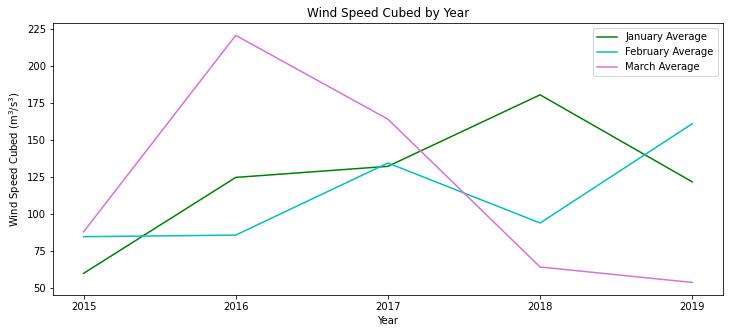

In [6]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(years,windjan, '-',color='green',label='January Average')
p2=ax.plot(years,windfeb, '-',color='c',label='February Average')
p3=ax.plot(years,windmar, '-',color='orchid',label='March Average')
ax.set_ylabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax.set_xlabel('Year')
ax.set_title('Wind Speed Cubed by Year')
ax.set_xticks([2015,2016,2017,2018,2019])
ax.legend(handles=[p1[0],p2[0],p3[0]],loc='upper right')

### Monthly average solar radiation (January-March)

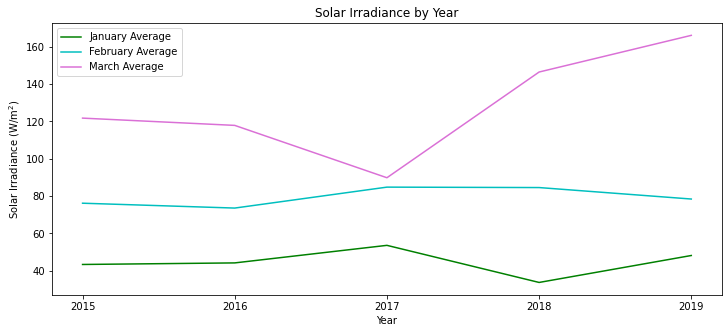

In [9]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(years,solarjan, '-',color='green',label='January Average')
p2=ax.plot(years,solarfeb, '-',color='c',label='February Average')
p3=ax.plot(years,solarmar, '-',color='orchid',label='March Average')
ax.set_ylabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax.set_xlabel('Year')
ax.set_title('Solar Irradiance by Year')
ax.set_xticks([2015,2016,2017,2018,2019])
ax.legend(handles=[p1[0],p2[0],p3[0]],loc='upper left')

### Monthly average photosynthetically available radiation (PAR) (January-March)

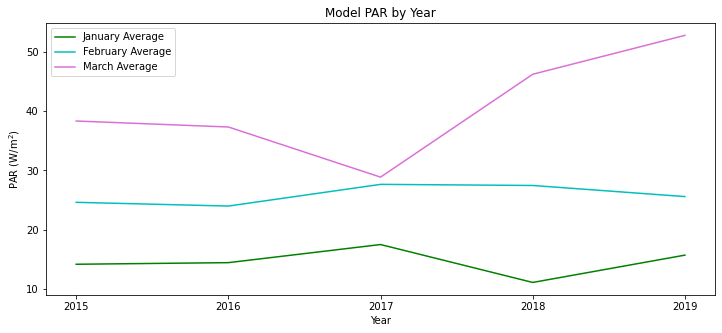

In [10]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(years,parjan, '-',color='green',label='January Average')
p2=ax.plot(years,parfeb, '-',color='c',label='February Average')
p3=ax.plot(years,parmar, '-',color='orchid',label='March Average')
ax.set_ylabel('PAR (W/$\mathregular{m^2}$)')
ax.set_xlabel('Year')
ax.set_title('Model PAR by Year')
ax.set_xticks([2015,2016,2017,2018,2019])
ax.legend(handles=[p1[0],p2[0],p3[0]],loc='upper left')

### Monthly average surface temperature (January-March)

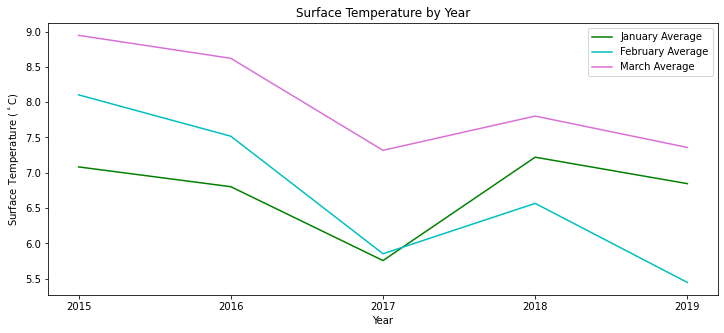

In [12]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(years,tempjan, '-',color='green',label='January Average')
p2=ax.plot(years,tempfeb, '-',color='c',label='February Average')
p3=ax.plot(years,tempmar, '-',color='orchid',label='March Average')
ax.set_ylabel('Surface Temperature ($^\circ$C)')
ax.set_xlabel('Year')
ax.set_title('Surface Temperature by Year')
ax.set_xticks([2015,2016,2017,2018,2019])
ax.legend(handles=[p1[0],p2[0],p3[0]],loc='upper right')

### Monthly average surface salinity (January-March)

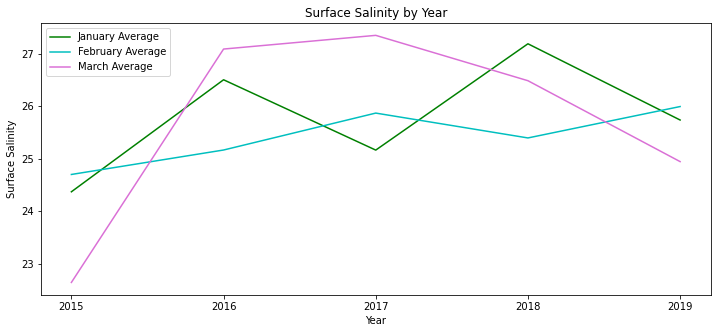

In [13]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(years,saljan, '-',color='green',label='January Average')
p2=ax.plot(years,salfeb, '-',color='c',label='February Average')
p3=ax.plot(years,salmar, '-',color='orchid',label='March Average')
ax.set_ylabel('Surface Salinity')
ax.set_xlabel('Year')
ax.set_title('Surface Salinity by Year')
ax.set_xticks([2015,2016,2017,2018,2019])
ax.legend(handles=[p1[0],p2[0],p3[0]],loc='upper left')
# what is the unit for salinity?

### Monthly average Fraser river flow (January-March)

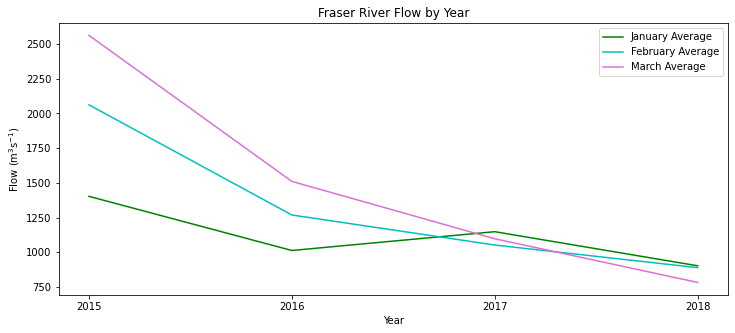

In [15]:
yearnot19=years[0:4]
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(yearnot19,fraserjan, '-',color='green',label='January Average')
p2=ax.plot(yearnot19,fraserfeb, '-',color='c',label='February Average')
p3=ax.plot(yearnot19,frasermar, '-',color='orchid',label='March Average')
ax.set_ylabel('Flow (m$^3$s$^{-1}$)')
ax.set_xlabel('Year')
ax.set_title('Fraser River Flow by Year')
ax.set_xticks([2015,2016,2017,2018])
ax.legend(handles=[p1[0],p2[0],p3[0]],loc='upper right')

### Monthly average surface zooplankton concentration (January-March)

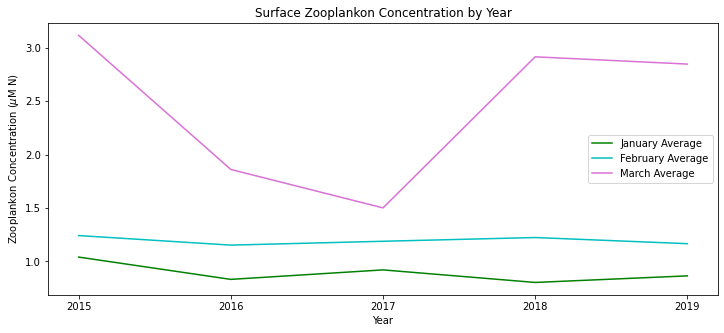

In [18]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
p1=ax.plot(years,zoojan, '-',color='green',label='January Average')
p2=ax.plot(years,zoofeb, '-',color='c',label='February Average')
p3=ax.plot(years,zoomar, '-',color='orchid',label='March Average')
ax.set_ylabel('Zooplankon Concentration ($\mu$M N)')
ax.set_xlabel('Year')
ax.set_title('Surface Zooplankon Concentration by Year')
ax.set_xticks([2015,2016,2017,2018,2019])
ax.legend(handles=[p1[0],p2[0],p3[0]],loc='center right')

### Nitrate

mid-depth nitrate, say 30-90m (try for each location)

January nitrate concentration in deep SoG (below 250 m)

In [20]:
no3_alld

array([[23.515175  , 23.554594  , 23.603527  , ...,  0.        ,
         0.        ,  0.        ],
       [23.571758  , 23.57355   , 23.580078  , ...,  0.        ,
         0.        ,  0.        ],
       [24.198307  , 24.19861   , 24.19911   , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.08288033,  0.08332632,  0.09127697, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0371336 ,  0.05146486,  0.09865781, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03236723,  0.04070939,  0.07257345, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [28]:
# b) get average no3 in upper 3m
no3_alld_df=pd.DataFrame(no3_alld)
no3_alld_df
#upper_3m_no3=no3_alld_df[250:]
#upper_3m_no3.columns=['upper_3m_no3']
#upper_3m_no3

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,23.515175,23.554594,23.603527,23.658932,23.707211,23.756565,23.807390,23.850113,23.888948,23.920668,...,28.655493,28.705704,28.729893,28.730452,0.0,0.0,0.0,0.0,0.0,0.0
1,23.571758,23.573549,23.580078,23.618185,23.680647,23.745729,23.813982,23.873266,23.940020,24.006979,...,28.643595,28.714565,28.755180,28.758980,0.0,0.0,0.0,0.0,0.0,0.0
2,24.198307,24.198610,24.199110,24.199781,24.200630,24.201689,24.203051,24.204964,24.208244,24.215879,...,28.698906,28.769850,28.798454,28.796621,0.0,0.0,0.0,0.0,0.0,0.0
3,23.992994,23.993858,23.995405,23.997711,24.000687,24.005335,24.012848,24.026379,24.054794,24.113146,...,28.746355,28.841621,28.862658,28.863733,0.0,0.0,0.0,0.0,0.0,0.0
4,23.666676,23.671400,23.684618,23.702757,23.719288,23.748533,23.772276,23.797523,23.830030,23.879538,...,28.781496,28.848213,28.865246,28.884823,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.249139,0.250048,0.272372,0.296945,0.357909,0.512107,0.829846,1.325657,2.913785,7.108970,...,27.519426,28.470781,28.744110,28.939680,0.0,0.0,0.0,0.0,0.0,0.0
86,0.178986,0.179665,0.184106,0.206280,0.309262,0.544323,1.075272,2.377133,5.026740,7.730538,...,27.412582,28.532671,28.886221,29.026134,0.0,0.0,0.0,0.0,0.0,0.0
87,0.082880,0.083326,0.091277,0.121230,0.205495,0.476379,0.855857,1.934850,4.332655,7.406206,...,27.412470,28.485342,28.976994,29.122942,0.0,0.0,0.0,0.0,0.0,0.0
88,0.037134,0.051465,0.098658,0.148937,0.247649,0.422142,0.922184,2.178910,4.146522,6.751084,...,27.533159,28.511713,28.937258,29.117840,0.0,0.0,0.0,0.0,0.0,0.0
